In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from scipy.signal import savgol_filter, lfilter
from skimage.restoration import denoise_wavelet, estimate_sigma
import pywt, os
from pykalman import KalmanFilter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import winsound
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq

In [37]:
df = pd.read_excel('./calibration_data/concantenate_mixed_data.xlsx')
df = df.drop(columns=['Unnamed: 0'])
df

,sensors,setpoint
0,8.6,20
1,8.6,20
2,9.0,20
3,8.6,20
4,8.6,20
...,...,...
6295,92.2,73
6296,92.2,73
6297,92.2,73
6298,91.9,73


In [3]:
def moving_average_filter(data, window_size=3):
    moving_average = []
    i = 0
    while i < (len(data) - window_size + 1):
        window_average = np.sum(data[i:i+window_size]) / window_size
        
        moving_average.append(
            round(window_average, 2)
        )
        i += 1

    return moving_average

def reshape_list(data, step):
    results = []
    for i in range(0, len(data), step):
        results.append(data[i])

    return results

def kalman_filter2(data, actual_data):
    state_mean = np.array([0, 0])  # Initial state mean
    state_cov = np.eye(2)  # Initial state covariance
    observation_cov = np.var(data)  # Measurement noise covariance

    # Kalman filter update
    state_estimates = []
    state_covariances = []

    for i in range(len(data)):
        # Prediction step
        state_mean_pred = state_mean[0] + state_mean[1] * data[i]
        state_cov_pred = state_cov + np.eye(2)
        
        # Measurement update step
        residual = actual_data[i] - state_mean_pred
        kalman_gain = state_cov_pred[0] / (state_cov_pred[0] + observation_cov)
        state_mean = state_mean_pred + kalman_gain * residual
        state_cov = (np.eye(2) - kalman_gain) @ state_cov_pred
        
        # Store the estimates
        state_mean_pred = round(state_mean_pred, 2)
        state_estimates.append(state_mean_pred)
        state_covariances.append(state_cov_pred[0, 0])

    
    return state_estimates

def notification():
    for _ in range(5):
        winsound.Beep(500, 200)
        winsound.Beep(1200, 200)
        winsound.Beep(500, 200)
        winsound.Beep(1200, 200)

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [4]:
polyreg_model = np.poly1d(np.polyfit(df.sensors, df.setpoint, 1))
regression = polyreg_model(df.sensors)

moving_average = moving_average_filter(regression)
savgol = savgol_filter(regression, 51, 2)

wavelet = pywt.wavedec(regression, 'db4')
wavelet = pywt.waverec(wavelet, 'db4',mode='symmetric',axis=-1)

wavelet2 = denoise_wavelet(regression, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')

kf = KalmanFilter(transition_matrices = [1],
observation_matrices = [1],
initial_state_mean = 0,
initial_state_covariance = 1,
observation_covariance=1,
transition_covariance=.0001)

mean, cov = kf.filter(regression)
mean, std = mean.squeeze(), np.std(cov.squeeze())

kalman2 = kalman_filter2(df.sensors,regression)

e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.sensors, df.setpoint, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.to_numpy().reshape(-1, 1))
# x_train_wavelet = denoise_wavelet(x_train, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')

x_test = scaler.transform(x_test.to_numpy().reshape(-1, 1))
# x_test_wavelet = denoise_wavelet(x_test, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')

In [6]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

class GRNN :

    def __init__(self,x_train,y_train,x_test,y_test):

        self.x_train= x_train
        self.y_train= y_train
        self.x_test= x_test
        self.y_test= y_test

        self.std     = np.ones((1,self.y_train.size))#np.random.rand(1,self.train_y.size) #Standard deviations(std) are sometimes called RBF widths.

    def activation_func(self,distances): # gaussian kernel
        
        return np.exp(- (distances**2) / 2*(self.std**2) )

    def output(self,i):#sometimes called weight

        distances=np.sqrt(np.sum((self.x_test[i]-self.x_train)**2,axis=1)) # euclidean distance
        
        return self.activation_func(distances)
   
    def denominator(self,i):

        return np.sum(self.output(i))

    def numerator(self,i): 

        return  np.sum(self.output(i) * self.y_train)
    
    def predict(self):

        predict_array = np.array([])

        for i in range(self.y_test.size):
            predict=np.array([self.numerator(i)/self.denominator(i)])
            predict_array=np.append(predict_array,predict)
        
        return predict_array
    
    def mean_squared_error(self):

        return (self.predict()-self.y_test)**2 /self.y_test.size

    def mean_absolute_error(self):

        return np.abs((self.predict()-self.y_test))/self.y_test.size
    
    def root_mean_squared_error(self):

        return np.sqrt(self.mean_squared_error())

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd).item()

model = tf.keras.models.Sequential()
# #v model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.Dense(8, activation='gelu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(1, activation='gelu'))
# model.add(tf.keras.layers.Dense(1, activation='linear'))

model.summary()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics = ["mae"])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='mean_squared_error', metrics = ["mae"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [7]:
learning_rate = 0.001
epochs = 2000
batch_size = 32

print(f"============================== Training ==============================")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))
# print(f"============================== Wavelet Training ==============================")
# history_wavelet = model.fit(x_train_wavelet, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test_wavelet, y_test))

notification()

============================== Training ==============================
Epoch 1/2000
158/158 [==============================] - 0s 961us/step - loss: 2633.7007 - mae: 48.9492 - val_loss: 2580.9041 - val_mae: 48.2687
Epoch 2/2000
158/158 [==============================] - 0s 544us/step - loss: 2555.0215 - mae: 48.1999 - val_loss: 2492.5029 - val_mae: 47.4032
Epoch 3/2000
158/158 [==============================] - 0s 535us/step - loss: 2458.6182 - mae: 47.2385 - val_loss: 2391.1064 - val_mae: 46.3707
Epoch 4/2000
158/158 [==============================] - 0s 529us/step - loss: 2352.6575 - mae: 46.1466 - val_loss: 2280.3408 - val_mae: 45.2202
Epoch 5/2000
158/158 [==============================] - 0s 519us/step - loss: 2235.2212 - mae: 44.9204 - val_loss: 2158.1980 - val_mae: 43.9231
Epoch 6/2000
158/158 [==============================] - 0s 539us/step - loss: 2105.9919 - mae: 43.5348 - val_loss: 2024.4404 - val_mae: 42.4583
Epoch 7/2000
158/158 [==============================] - 0s 516us/

In [18]:
mae_raw = mae(df.sensors, df.setpoint)
mae_raw = round(mae_raw, 2)
snr_raw = signaltonoise(df.sensors)
snr_raw = round(snr_raw, 2)

mae_regression = mae(regression, df.setpoint)
mae_regression = round(mae_regression, 2)
snr_regression = signaltonoise(regression)
snr_regression = round(snr_regression, 2)

mae_savgol = mae(savgol, df.setpoint)
mae_savgol = round(mae_savgol, 2)
snr_savgol = signaltonoise(savgol)
snr_savgol = round(snr_savgol, 2)

mae_wavelet = mae(wavelet, df.setpoint)
mae_wavelet = round(mae_wavelet, 2)
snr_wavelet = signaltonoise(wavelet)
snr_wavelet = round(snr_wavelet, 2)

mae_wavelet2 = mae(wavelet2, df.setpoint)
mae_wavelet2 = round(mae_wavelet2, 2)
snr_wavelet2 = signaltonoise(wavelet2)
snr_wavelet2 = round(snr_wavelet2, 2)

mae_moving_average = mae(moving_average, df.setpoint[1:len(df.setpoint)-1])
mae_moving_average = round(mae_moving_average, 2)
snr_moving_average = signaltonoise(moving_average)
snr_moving_average = round(snr_moving_average, 2)

mae_kalman = mae(mean, df.setpoint)
mae_kalman = round(mae_kalman, 2)
snr_kalman = signaltonoise(mean)
snr_kalman = round(snr_kalman, 2)

new_sensor_data = scaler.transform(df.sensors.to_numpy().reshape(-1, 1))
predictions = model.predict(new_sensor_data)
mae_deep_learning = mae(predictions, df.setpoint)
mae_deep_learning = round(mae_deep_learning, 2)
snr_deep_learning = signaltonoise(predictions)
snr_deep_learning = round(snr_deep_learning, 2)

predictions_wavelet = denoise_wavelet(np.squeeze(predictions), method='VisuShrink', mode='hard', wavelet_levels=6, wavelet='haar', rescale_sigma='True')
mae_deep_learning_wavelet = mae(predictions_wavelet, df.setpoint)
mae_deep_learning_wavelet = round(mae_deep_learning_wavelet, 2)
snr_deep_learning_wavelet = signaltonoise(predictions_wavelet)
snr_deep_learning_wavelet = round(snr_deep_learning_wavelet, 2)
print(f"MAE DL Wavelet : {mae_deep_learning_wavelet}")


savgol_deep_learning = savgol_filter(np.squeeze(predictions), 51, 2)
mae_deep_learning_savgol = mae(savgol_deep_learning, df.setpoint)
mae_deep_learning_savgol = round(mae_deep_learning_savgol, 2)
snr_deemae_deep_learning_savgol = signaltonoise(savgol_deep_learning)
snr_deemae_deep_learning_savgol = round(snr_deemae_deep_learning_savgol, 2)
print(f"MAE DL Savgol : {mae_deep_learning_savgol}")

deep_learning_fourier = filter_signal(np.squeeze(predictions), threshold=1e12)
mae_deep_learning_fourier = mae(deep_learning_fourier, df.setpoint)
mae_deep_learning_fourier = round(mae_deep_learning_fourier, 2)
print(f"MAE DL Fourier : {mae_deep_learning_fourier}")
# mae_rf = mae(rf_data, df.setpoint)
# mae_rf = round(mae_rf, 2)

# mae_gaussian_regression = mae(np.squeeze(gaussian_regression), df.setpoint)
# mae_gaussian_regression = round(mae_gaussian_regression, 2)

# x_train, x_test, y_train, y_test = train_test_split(df.sensors, df.setpoint, test_size=0.2, random_state=42)
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train.to_numpy().reshape(-1, 1))
# x_test = scaler.transform(x_test.to_numpy().reshape(-1, 1))

# x_test_wavelet = denoise_wavelet(x_test, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')
# model_GRNN = GRNN(x_train.reshape(-1,1), y_train.to_numpy().reshape(-1,1), x_test.reshape(-1,1), y_test.to_numpy().reshape(-1,1))
# mae_GRNN = model_GRNN.mean_absolute_error()
# mae_kalman2 = mae(kalman2, df.setpoint)
# mae_kalman2 = round(mae_kalman2, 2)

# notification()

197/197 [==============================] - 0s 316us/step
MAE DL Wavelet : 0.2
MAE DL Savgol : 0.25
MAE DL Fourier : 0.29


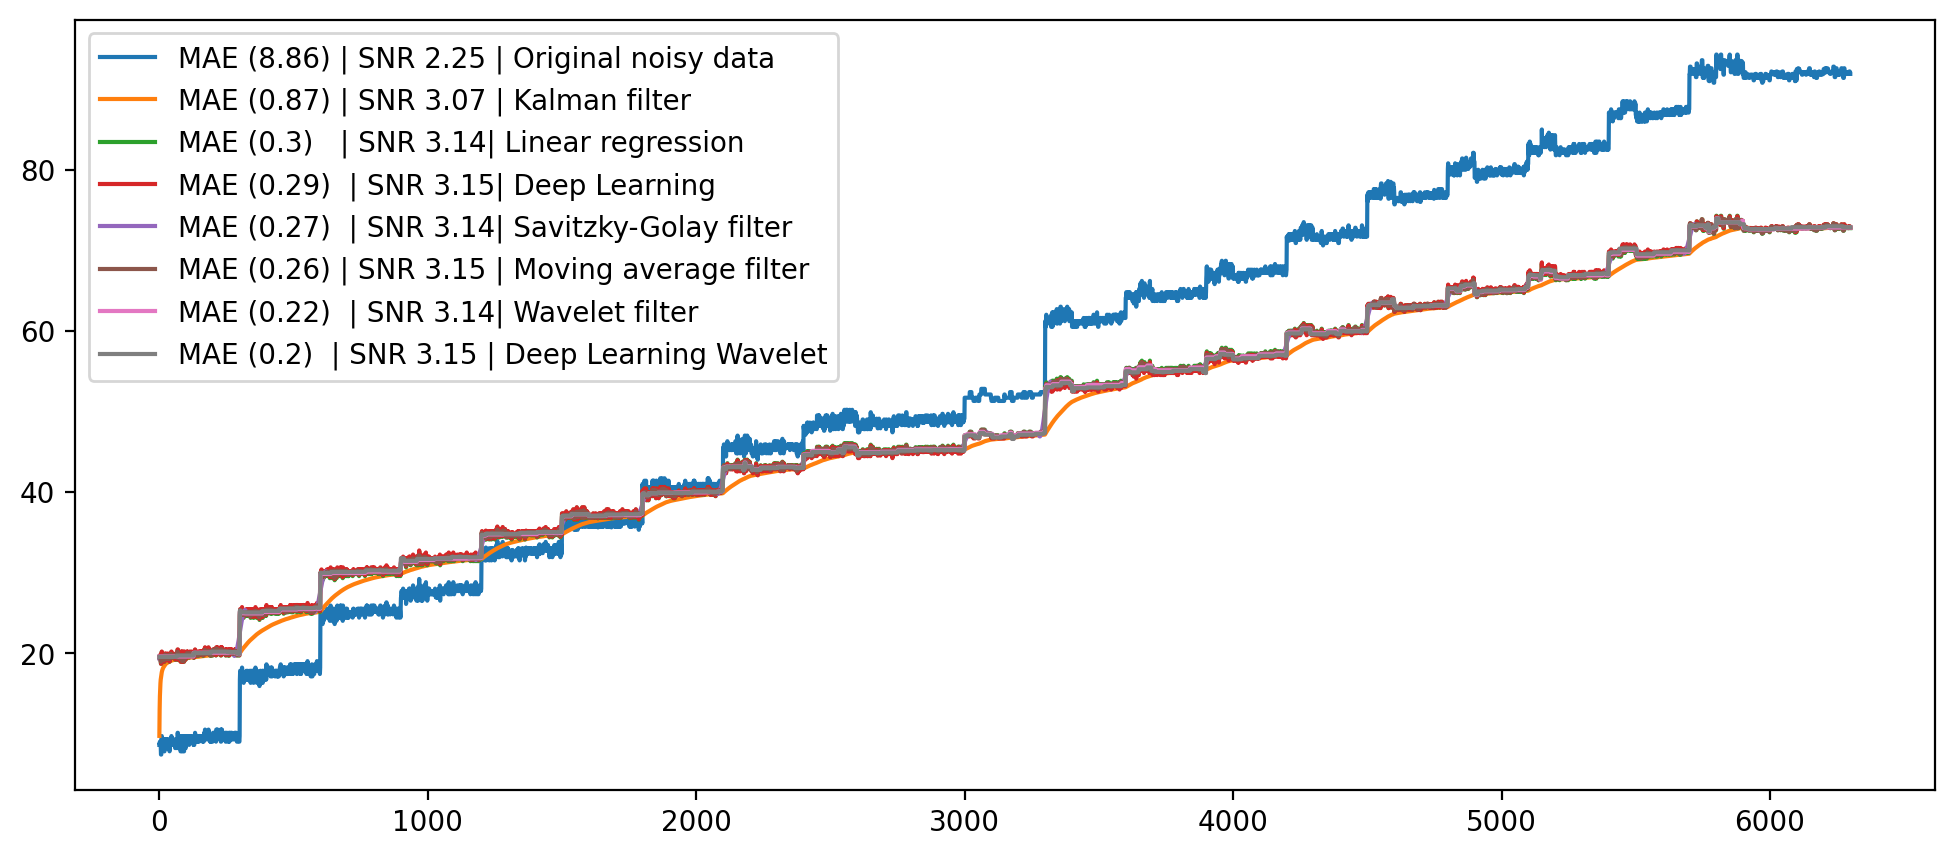

In [19]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=200)

ax.plot(df.sensors, label=f'MAE ({mae_raw}) | SNR {snr_raw} | Original noisy data')
ax.plot(mean, label=f'MAE ({mae_kalman}) | SNR {snr_kalman} | Kalman filter')
ax.plot(regression, label=f'MAE ({mae_regression})   | SNR {snr_regression}| Linear regression')
ax.plot(predictions, label=f'MAE ({mae_deep_learning})  | SNR {snr_deep_learning}| Deep Learning')
ax.plot(savgol, label=f'MAE ({mae_savgol})  | SNR {snr_savgol}| Savitzky-Golay filter')
# ax.plot(wavelet, label=f'MAE ({mae_wavelet}) | Wavelet filter 1')
ax.plot(moving_average, label=f'MAE ({mae_moving_average}) | SNR {snr_moving_average} | Moving average filter')
ax.plot(wavelet2, label=f'MAE ({mae_wavelet2})  | SNR {snr_wavelet2}| Wavelet filter')
ax.plot(predictions_wavelet, label=f'MAE ({mae_deep_learning_wavelet})  | SNR {snr_deep_learning_wavelet} | Deep Learning Wavelet')


plt.legend()
plt.show()

40/40 [==============================] - 0s 365us/step - loss: 0.1388 - mae: 0.2908
Test Loss: 0.13877888023853302
Test MAE: 0.2908480167388916


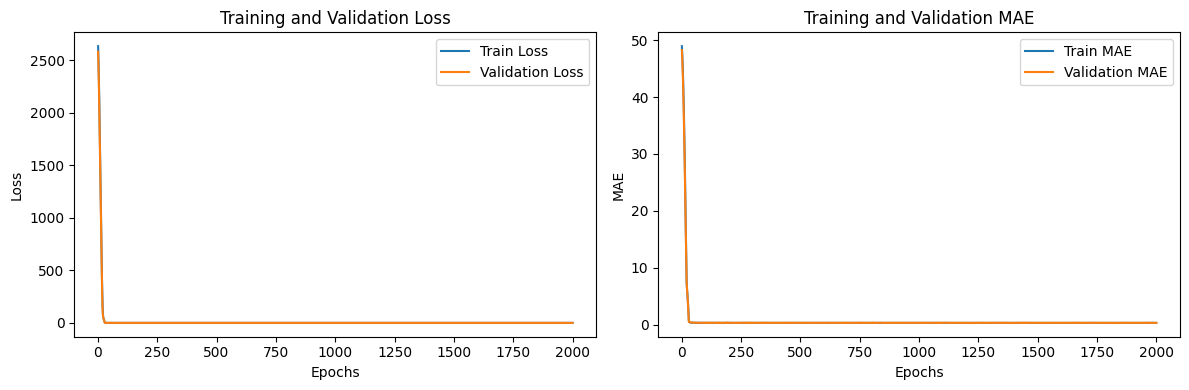

In [20]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# Step 8: Plot accuracy and loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

pd.DataFrame({
    'train_loss':train_loss,
    'val_loss':val_loss,
    'train_mae':train_mae,
    'val_mae':val_mae,
    }).to_excel('./training_results/8_elu_1_elu_0.32_0.3005_MAE_noisy_0.24.xlsx')
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Train MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

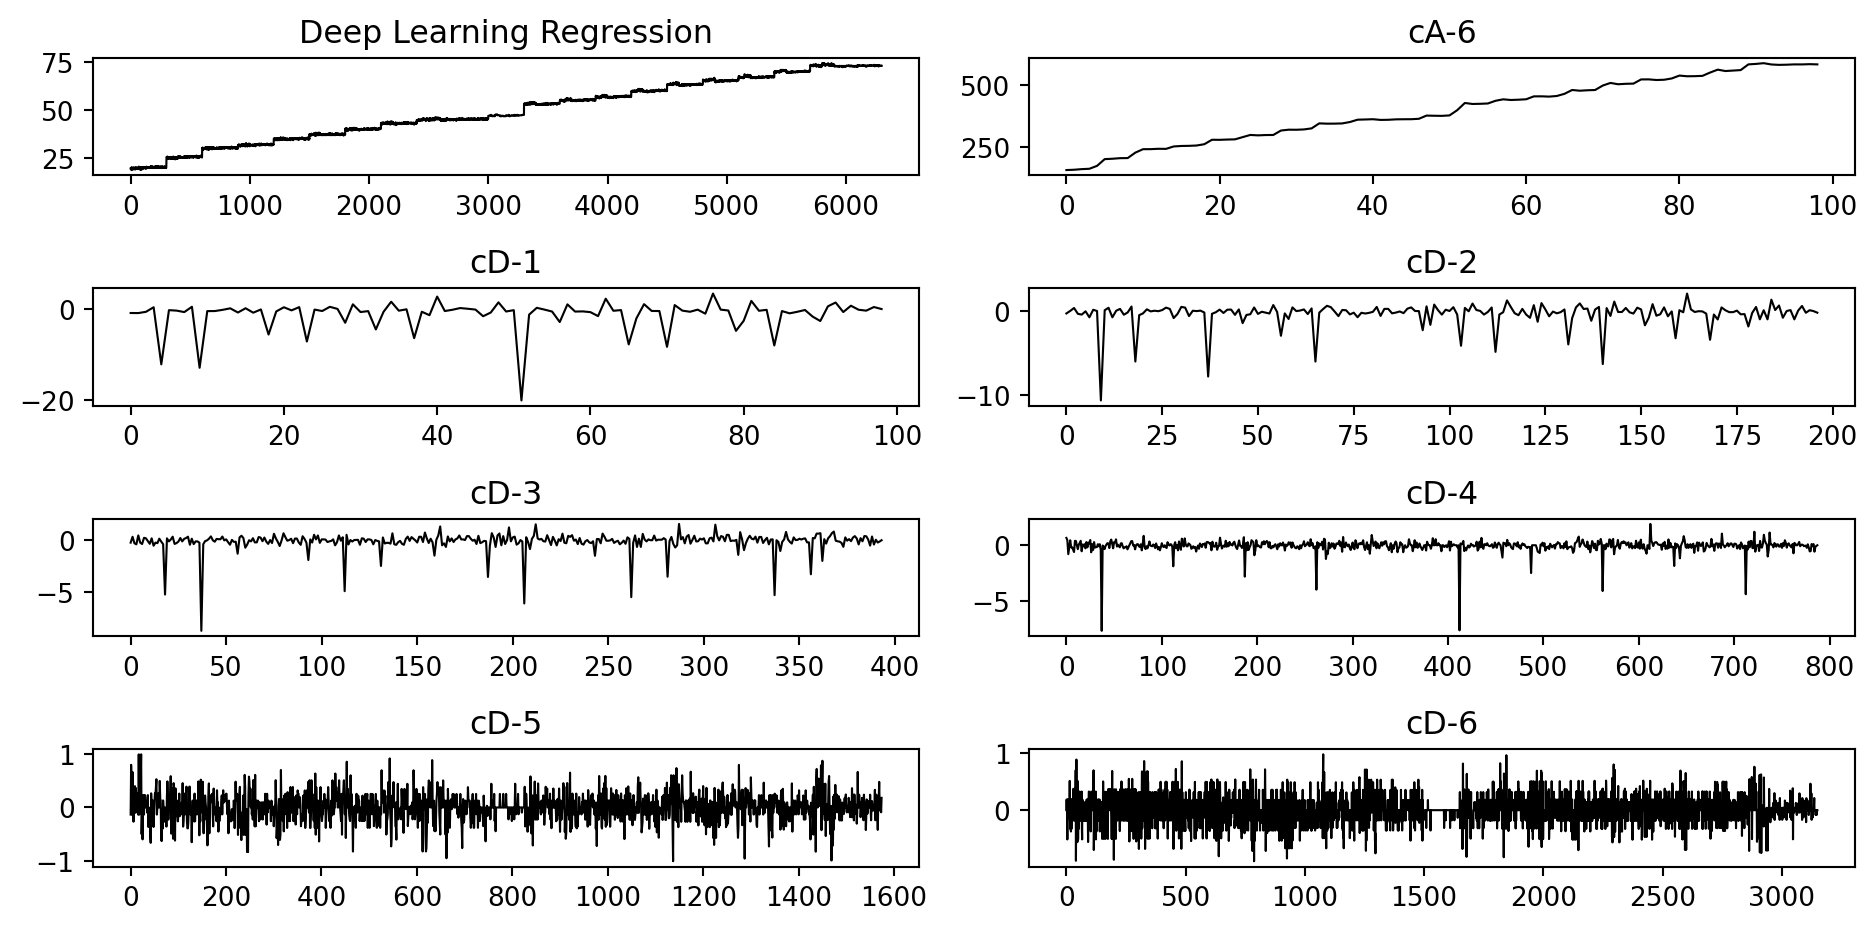

In [21]:
coef = pywt.wavedec(np.squeeze(predictions), 'haar', level=6)
fig, ax = plt.subplots(4, 2, figsize=(10,5), dpi=190)
count = 0
for row in range(0, 4):
    for col in range(0, 2):
        if ((row == 0) and (col == 0)):
            ax[row][col].plot(np.squeeze(predictions), color='k', linewidth=0.8)
            ax[row][col].set_title(f"Deep Learning Regression")
        else:
            if count == 0:
                ax[row][col].plot(coef[count], color='k', linewidth=0.8)
                ax[row][col].set_title(f"cA-6")
            else:
                ax[row][col].plot(coef[count], color='k', linewidth=0.8)
                ax[row][col].set_title(f"cD-{count}")
            
            count += 1
plt.tight_layout()
plt.show()

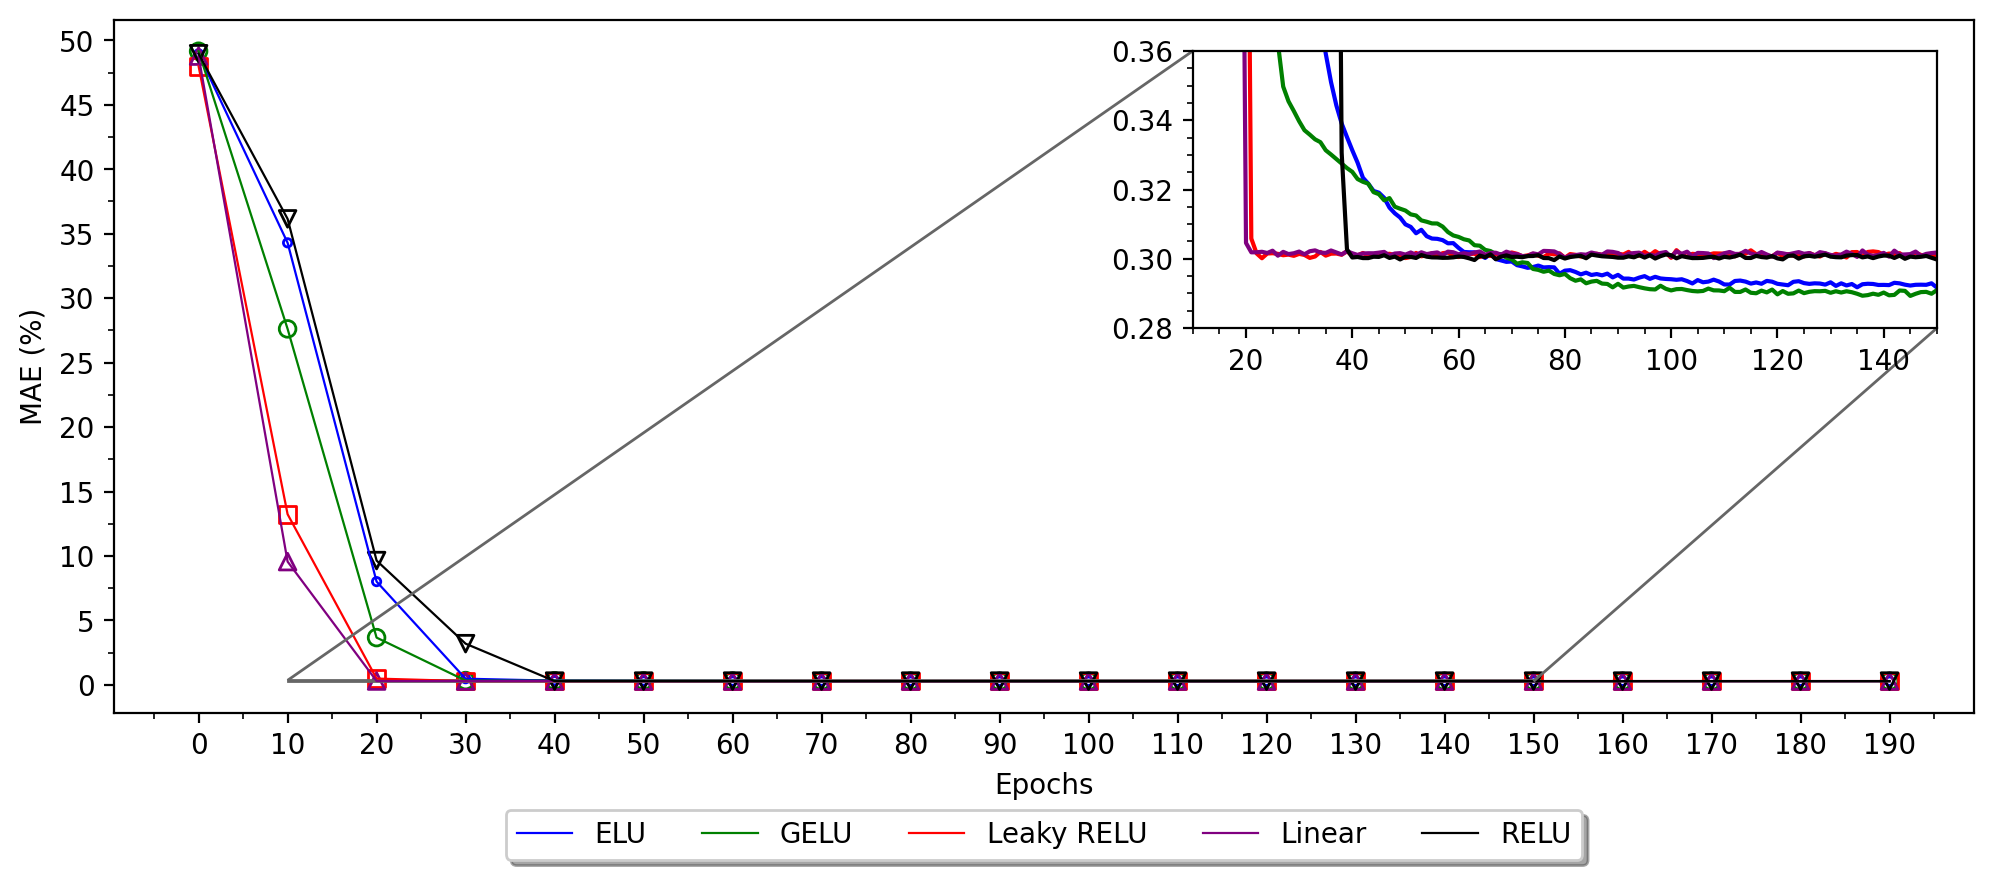

In [206]:
fig, ax = plt.subplots(1, figsize=(12, 5), dpi=200)
function_name = ["ELU", "GELU", "Leaky RELU", "Linear", "RELU"]
markers = ['.', 'o', 's', '^', 'v']
colors = ['blue', 'green', 'red', 'purple', 'black']
count = 0
index_hop = 10
end_epoch = 200

for i in os.listdir('./training_results/'):
    df_data = pd.read_excel(f'./training_results/{i}')
    ax.scatter(df_data.index[:end_epoch][::index_hop], df_data.train_mae[:end_epoch][::index_hop], marker=markers[count], facecolors='none', edgecolors=colors[count])
    ax.plot(df_data.index[:end_epoch][::index_hop], df_data.train_mae[:end_epoch][::index_hop], label=function_name[count], color=colors[count], linewidth=0.8)
    count += 1

ax.set_ylabel("MAE (%)")
ax.set_xlabel("Epochs")
# Create the zoomed-in plot
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax_zoom = ax.inset_axes([0.580, 0.555, 0.4, 0.4]) 
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.4")
# For the minor ticks, use no labels; default NullFormatter.


ax_zoom.set_ylim(0.28, 0.36)
ax_zoom.set_xlim(10, 150)
ax_zoom.yaxis.set_major_locator(MultipleLocator(0.02))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.005))
ax_zoom.xaxis.set_major_locator(MultipleLocator(20))
ax_zoom.xaxis.set_major_formatter('{x:.0f}')
ax_zoom.xaxis.set_minor_locator(MultipleLocator(5))

count = 0
for i in os.listdir('./training_results/'):
    df_data = pd.read_excel(f'./training_results/{i}')
    ax_zoom.plot(df_data.train_mae.to_numpy()[:250], label=i, color=colors[count])
    count += 1


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5)

plt.show()

In [173]:
df[:10][::2]

,sensors,setpoint
0,8.6,20
2,9.0,20
4,8.6,20
6,7.4,20
8,8.6,20
